# Using EMLP in PyTorch

So maybe you haven't yet realized that Jax is the best way of doing deep learning -- that's ok!

You can use EMLP and the equivariant linear layers _in PyTorch_. Simply replace `import emlp.nn as nn` with `import emlp.nn.pytorch as nn`.

If you're using a GPU (which we recommend), you will want to set the environment variable so that Jax doesn't steal all of the GPU memory from PyTorch. Note that if a GPU is visible under `CUDA_VISIBLE_DEVICES`, you must use the PyTorch EMLP on the GPU.

In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
import torch
import emlp.nn.pytorch as nn

In [3]:
from emlp.reps import T,V
from emlp.groups import SO13

repin= 4*V # Setup some example data representations
repout = V**0
G = SO13() # The lorentz group

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
x = torch.randn(5,repin(G).size()).to(device) # generate some random data

model = nn.EMLP(repin,repout,G).to(device) # initialize the model

model(x)

Krylov Solving for Equivariant Subspace r<=10:   0%|          | 0/100 [00:00<?, ?it/s]

Krylov Solving for Equivariant Subspace r<=20:   0%|          | 0/100 [00:00<?, ?it/s]

Krylov Solving for Equivariant Subspace r<=40:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[-0.0039],
        [-0.0041],
        [-0.0042],
        [-0.0040],
        [-0.0039]], device='cuda:0', grad_fn=<AddmmBackward>)

The model is a standard pytorch module.

In [5]:
model

EMLP(
  (network): Sequential(
    (0): EMLPBlock(
      (linear): Linear(in_features=16, out_features=419, bias=True)
      (bilinear): BiLinear()
      (nonlinearity): GatedNonlinearity()
    )
    (1): EMLPBlock(
      (linear): Linear(in_features=384, out_features=419, bias=True)
      (bilinear): BiLinear()
      (nonlinearity): GatedNonlinearity()
    )
    (2): EMLPBlock(
      (linear): Linear(in_features=384, out_features=419, bias=True)
      (bilinear): BiLinear()
      (nonlinearity): GatedNonlinearity()
    )
    (3): Linear(in_features=384, out_features=1, bias=True)
  )
)

## Example Training Loop

Ok what about training and autograd and all that? As you can see the training loop is very similar to the objax one in [Constructing Equivariant Models](https://equivariant-mlp.readthedocs.io/en/latest/notebooks/2building_a_model.html).

In [6]:
import torch
import emlp.nn.pytorch as nn
from emlp.groups import SO13
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from emlp.datasets import ParticleInteraction

trainset = ParticleInteraction(300) # Initialize dataset with 1000 examples
testset = ParticleInteraction(1000)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BS=500
lr=3e-3
NUM_EPOCHS=500

model = nn.EMLP(trainset.rep_in,trainset.rep_out,group=SO13(),num_layers=3,ch=384).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

def loss(x, y):
    yhat = model(x.to(device))
    return ((yhat-y.to(device))**2).mean()

def train_op(x, y):
    optimizer.zero_grad()
    lossval = loss(x,y)
    lossval.backward()
    optimizer.step()
    return lossval

trainloader = DataLoader(trainset,batch_size=BS,shuffle=True)
testloader = DataLoader(testset,batch_size=BS,shuffle=True)

test_losses = []
train_losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    train_losses.append(np.mean([train_op(*mb).cpu().data.numpy() for mb in trainloader]))
    if not epoch%10:
        with torch.no_grad():
            test_losses.append(np.mean([loss(*mb).cpu().data.numpy() for mb in testloader]))

  0%|          | 0/500 [00:00<?, ?it/s]

Ok so it's not nearly as fast as in Jax (maybe 15x slower), but hey you said you wanted PyTorch

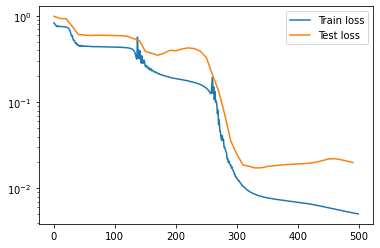

In [7]:
import matplotlib.pyplot as plt
plt.plot(np.arange(NUM_EPOCHS),train_losses,label='Train loss')
plt.plot(np.arange(0,NUM_EPOCHS,10),test_losses,label='Test loss')
plt.legend()
plt.yscale('log')

Bonus: Try out `model=nn.MLP(trainset.rep_in,trainset.rep_out,group=SO13()).to(device)` and see how well it performs on this problem.

## Converting Jax functions to PyTorch functions (how it works)

You can use the underlying equivariant bases $Q\in \mathbb{R}^{n\times r}$ and projection operators $P = QQ^\top$ in pytorch also.

Since these objects are implicitly defined through `LinearOperators`, it is not as straightforward as simply calling `torch.from_numpy(Q)`. However, there is a way to use these operators within PyTorch code while preserving any gradients of the operation. We provide the function `emlp.reps.pytorch_support.torchify_fn` to do this.

In [ ]:
import jax
import jax.numpy as jnp
from emlp.reps import V
from emlp.groups import S

For example, let's setup a representation $S_4$ consisting of three vectors and one matrix.

In [8]:
W =V(S(4))
rep = 3*W+W**2

First we compute the equivariant basis and equivariant projector linear operators, and then wrap them as functions.

In [9]:
Q = (rep>>rep).equivariant_basis()
P = (rep>>rep).equivariant_projector()

In [10]:
applyQ = lambda v: Q@v
applyP = lambda v: P@v

We can convert any pure pytorch function into a jax function by applying `torchify_fn`. Now instead of taking jax objects as inputs and outputing jax objects, these functions take in PyTorch objects and output PyTorch objects.

In [11]:
from emlp.nn.pytorch import torchify_fn
applyQ_torch = torchify_fn(applyQ)
applyP_torch = torchify_fn(applyP)

As you would hope, gradients are correctly propagated whether you use the original Jax functions or the torchified pytorch functions.

In [12]:
x_torch = torch.arange(Q.shape[-1]).float().cuda()
x_torch.requires_grad=True
x_jax  = jnp.asarray(x_torch.cpu().data.numpy()) 

In [13]:
Qx1 = applyQ(x_jax)
Qx2 = applyQ_torch(x_torch)
print("jax output: ",Qx1[:5])
print("torch output: ",Qx2[:5])

jax output:  [0.48484263 0.07053992 0.07053989 0.07053995 1.6988853 ]
torch output:  tensor([0.4848, 0.0705, 0.0705, 0.0705, 1.6989], device='cuda:0',
       grad_fn=<SliceBackward>)


The outputs match, and note that the torch outputs will be on whichever is the default jax device. Similarly, the gradients of the two objects also match:

In [14]:
torch.autograd.grad(Qx2.sum(),x_torch)[0][:5]

tensor([-2.8704,  2.7858, -2.8704,  2.7858, -2.8704], device='cuda:0')

In [15]:
jax.grad(lambda x: (Q@x).sum())(x_jax)[:5]

DeviceArray([-2.8703732,  2.7858496, -2.8703732,  2.7858496, -2.8703732],            dtype=float32)

So you can safely use these torchified functions within your model, and still compute the gradients correctly.

We use this `torchify_fn` on the projection operators to convert EMLP to pytorch.